In [59]:
using Revise

In [191]:
using
    UnitsToValue,
    Printf,
    Plots,
    ImageFiltering
;

include("CaF_package.jl")
include("helper_functions.jl")
include("analyze_results.jl")
include("load_save_results.jl")
;

## Define CaOH Hamiltonian and molecular states

In [192]:
package = get_CaF_package(); # loads molecular structure (the states, their energy, Zeeman Hamiltonian, etc)
package_A = get_CaF_package_12_A_states(); # this includes more A states, for calculating AC Stark shift in the ODT.
k = package.k
Γ = package.Γ
m = package.m
λ = 2π / k

# add a 4.8 MHz hyperfine splitting in the A state
package.states[14].E += 4.8e6
package.states[15].E += 4.8e6
package.states[16].E += 4.8e6
;

## Define experimental parameters

In [211]:
## Initial condition of the molecule cloud
temp = @with_unit 100 "μK"
diameter = @with_unit 0.2 "mm"
displacement = [0.0, 0.0, 0.0]*1e-3
kick = [0,0, 0.0, 0.0]
 
## Define B field gradient and ramp time
B_gradient = -27.0 * 0
ramp_time = 1e-6

## Laser detunings
energy_F2_to_F1lower = (energy(package.states[10]) - energy(package.states[1]))
energy_F2_to_F1upper = (energy(package.states[10]) - energy(package.states[5]))

Δ1 = 1e6 * (24)
Δ2 = 1e6 * (21.3 + 0.8) #- 2π * energy_F2_to_F1lower
Δ3 = 1e6 * (21.3 - 1) - 2π * energy_F2_to_F1upper
Δ4 = 0.0
Δ5 = Δ1

# ## Laser intensities
# Isat = π*h*c*Γ/(3λ^3) / 10

# I = 5.8 # mW/cm^2, for each beam
# s = I / Isat

s_total = 3

s1 = 1/(1+2) * s_total
s2 = 0
s3 = 0
s4 = 0.
s5 = 2/(1+2) * s_total

blue_MOT_params = MutableNamedTuple(t_start = 0.0, t_end = 5e-3, n_values = 20,
                                pol1_x=σ⁻, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁻, pol5_x = σ⁺, 
                                s1=s1, s2=s2, s3=s3, s4=s4,s5 = s5,
                                Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, Δ5 =Δ5,

                                B_gradient = B_gradient, 
                                B_ramp_time = ramp_time,
                                Bz_offset = 0.0, By_offset = 0.0, Bx_offset=0.0,

                                temp=temp, diameter=diameter, 
                                displacement=displacement, kick=kick,
                                s_ramp_time = ramp_time,
                                s_ramp_to_factor = 1.0,

                                photon_budget=Inf, dark_lifetime=1/(0.7e6)*Γ, FC_mainline=1,

                                pol_imbalance=0.0, 
                                s_imbalance = (0., 0., -0.), retro_loss=0., 
                                off_center=[0, -0, -0, 0, 0, 0].*1e-3, 
                                pointing_error =[0.0, 0.0, 0.0,0.0,0,0],

                                ODT_intensity = 0*13.3*1e3/(50e-4)^2,
                                ODT_size = (30e-6, 2e-3, 30e-6), 
                                ODT_revolutions = 3,
                                ODT_rmax = 100e-6, # distance of radial motion
                                ODT_tmax = 30e-3, # timescale of radial motion
                                ODT_motion_t_start = 30e-3,
                                ODT_motion_t_stop = 50e-3,

                                dt = 5e-3,

                                diffusion_constant = 0.0)
;

## Find the diffusion constant

In [212]:
res, diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=2e-4, n_particles=20, 
                                            ramp_time=1e-6, temp = 150e-6, diameter=80e-6)
@printf("Diffusion constant = %.2f \n", diffusion_constant)

blue_MOT_params.diffusion_constant = diffusion_constant;

┌ Warning: Instability detected. Aborting
└ @ SciMLBase C:\Users\halla\.julia\packages\SciMLBase\szsYq\src\integrator_interface.jl:606
Progress: 100%|█████████████████████████████████████████| Time: 0:02:51


Diffusion constant = 0.18 


In [213]:
blue_MOT_params.n_values = 100
sequence = [blue_MOT_params]
durations = [2e-3]
generate_sequence!(sequence, durations);
@time results = simulate_particles_constant_diffusion(package, package_A, sequence);
# x = plot_size(results, "x")[2][end]*1e3
# y = plot_size(results, "y")[2][end]*1e3
# z = plot_size(results, "z")[2][end]*1e3
# Tx = plot_temperature(results,"x")[2][end]
# Ty = plot_temperature(results,"y")[2][end]
# Tz = plot_temperature(results,"z")[2][end]
# @printf("Size = (%.1f, %.1f, %.1f) um \n", x,y,z)
# @printf("Temperature = (%.1f, %.1f, %.1f) uK \n", Tx,Ty,Tz)
# @printf("goodness = %.5f",  goodness(blue_MOT_params.t_end, results))

Progress: 100%|█████████████████████████████████████████| Time: 0:03:46


226.111075 seconds (181.26 k allocations: 37.279 MiB)


In [214]:
plot_scattering_rate(results)

0.2717099084793502

In [215]:
bootstrap_temperature_fit(results,2;iter=100)

(285.04189912288945, 60.87479420657073)

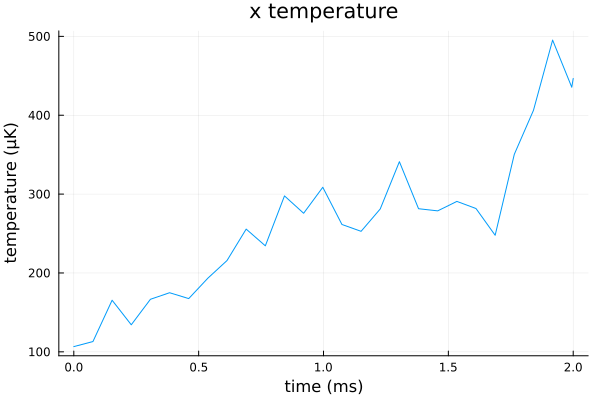

In [217]:
plot_temperature(results,"x")
plot!()

## Run a constant-diffusion simulation
Define an experimental sequence. In this example, it's just the blue MOT. But we could also simulate an entire experimental sequence, such as 
red MOT -> lambda cooling -> blue MOT -> single frequency cooling -> ODT loading

In [93]:
# δs = -1:0.2:1
# results_list = []

# for δ in δs
#     Δ = 21.3
#     Δ1 =  2π * 1e6 * Δ
#     Δ2 =  2π * 1e6 * (Δ + δ) - 2π * energy_F2_to_F1lower
#     blue_MOT_params.Δ1 = Δ1
#     blue_MOT_params.Δ2 = Δ2
    
#     @printf("δ = %.2f MHz \n", δ)
#     results1, diffusion_constant = find_diffusion_constant(blue_MOT_params, run_time=1e-4, n_particles=20, 
#                                             ramp_time=1e-6, temp = 160e-4, diameter=100e-6)
#     blue_MOT_params.diffusion_constant = diffusion_constant
#     @printf("Diffusion const = %.2f \n", diffusion_constant)
    
#     sequence = [blue_MOT_params]
#     durations = [10e-3]
#     generate_sequence!(sequence, durations);
#     results = simulate_particles_constant_diffusion(package, package_A, sequence)
#     push!(results_list, results)
    
#     x = plot_size(results, "x")[2][end]*1e3
#     y = plot_size(results, "y")[2][end]*1e3
#     z = plot_size(results, "z")[2][end]*1e3
#     Tx = plot_temperature(results,"x")[2][end]
#     Ty = plot_temperature(results,"y")[2][end]
#     Tz = plot_temperature(results,"z")[2][end]
#     @printf("Size = (%.1f, %.1f, %.1f) um \n", x,y,z)
#     @printf("Temperature = (%.1f, %.1f, %.1f) uK \n", Tx,Ty,Tz)
#     @printf("goodness = %.5f",  goodness(blue_MOT_params.t_end, results))
#     println()
#     println()
# end

281.4366851402391


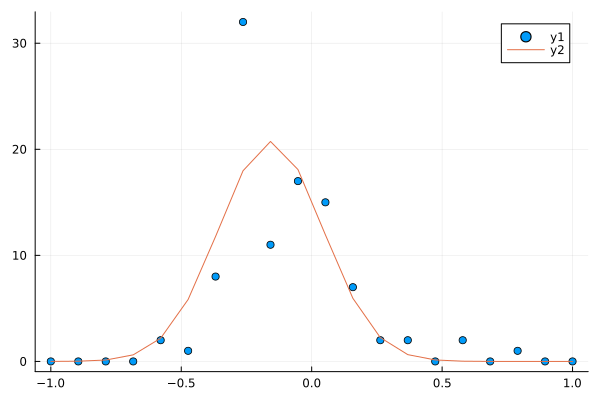

┌ Warning: G:\My Drive\github\OpticalBlochEquations\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573
┌ Warning: G:\My Drive\github\QuantumStates\src is not an existing directory, Revise is not watching
└ @ Revise C:\Users\halla\.julia\packages\Revise\bAgL0\src\packagedef.jl:573


In [224]:
n_values = 100

sizes = []
x_grid = collect(LinRange(-1, 1, 20))

results1 = bootstrap_iteration(results, n_values=n_values)

id_survived = survived_t(results,2)

xs = [results1.x_velocities[j][end] for j in id_survived]
density_x = distribution_to_func(x_grid, xs)


p0 = [10, 0.1,0.0]
fit = curve_fit(gaussian, x_grid, density_x, p0);
k_B = 1.38e-23

# println(fit.param[2])
# println(plot_size(results1, "x")[2][end])
    println(m * fit.param[2]^2 /k_B *1e6)

# println(plot_temperature(results1, "x")[2][end])
scatter(x_grid, density_x)
plot!(x_grid, gaussian(x_grid, fit.param))

In [220]:
Δ = 13; 22
s_total=1, s1=0.6, s2 = 0.4, \DeltΔ.3, \delta = 0.8

LoadError: cannot assign a value to imported variable QuantumStates.Δ from module Main

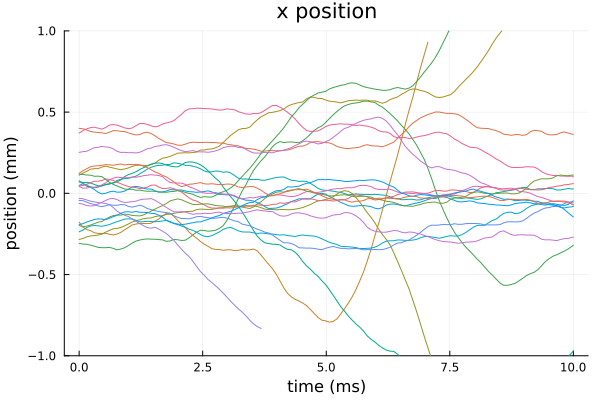

In [15]:
plot_all_trajectories(results_list[end-1],"x")
plot!(ylim=[-1,1])

In [8]:
# blue_MOT_params.n_values = 20
# sequence = [blue_MOT_params]
# durations = [20e-3]
# generate_sequence!(sequence, durations);
# @time results = simulate_particles_constant_diffusion(package, package_A, sequence);

## Plot simulation results

### Plot the molecules' trajectories

Note that molecules that are too far away from the centre are discarded, which is why some trajectories end prematurely.

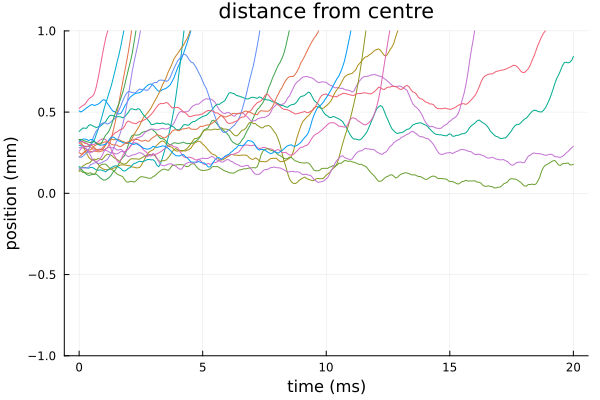

In [88]:
plot_all_trajectories(results, "all")
plot!(ylim=[-1,1])

### Plot the cloud size over time 
The size here is obtained from the standard deviation of the position distribution.
There is also an option to find the final cloud size by fitting to a Gaussian.

Final size = 0.197 mm

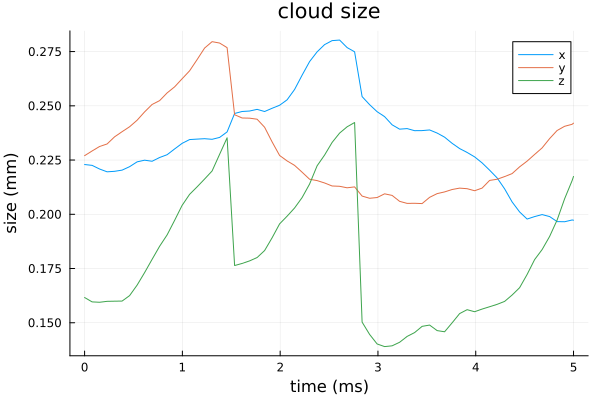

In [86]:
~, σ = plot_size(results,"all")
@printf("Final size = %.3f mm", σ[end])
plot!()

### Plot temperature over time 
Temperatures here are obtained from the standard deviation of the velocity distribution. One could also fit the velocity distribution to a Gaussian.

Temperature = 299.8 uK

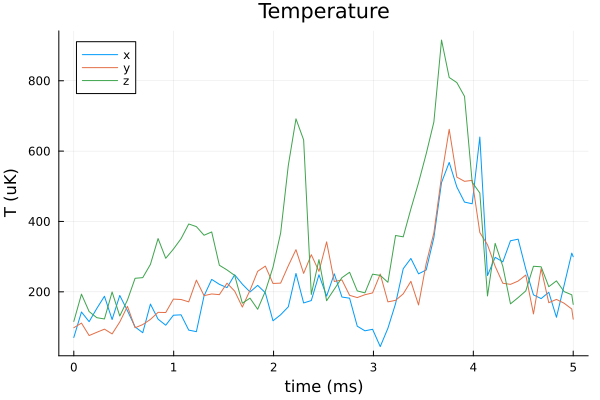

In [79]:
~, T = plot_temperature(results, "all")
@printf("Temperature = %.1f uK", T[end])
plot!()

### Plot the scattering rate of the molecules 
Scattering rate = excited state population * Γ

Average scattering rate = 0.71 MHz

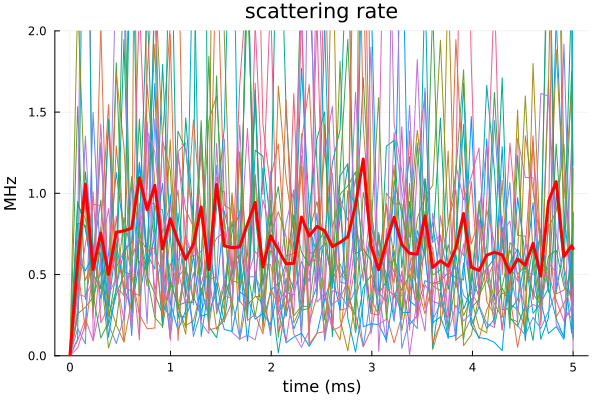

In [207]:
sr = plot_scattering_rate(results)
@printf("Average scattering rate = %.2f MHz", sr)
plot!(ylim=[0,2])

### Simulate camera images
We can also generate "camera images" by taking 2D snapshots (integrated over y direction) of the molecules.

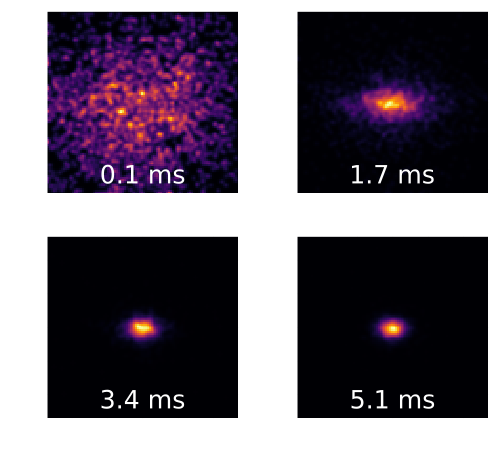

In [32]:
ROI = 0.8  # mm

img_duration = 2.0   # the image will be averaged over this duration
n_pixels = 100

ts = [0.1,1.7,3.4,5.1]
filter = 1.   # Gaussian filtering the image

plots = []
for t in ts
    x, z, grids = take_camera_image(results, -ROI, ROI, n_pixels, t=t, t_img=img_duration, const_scattering=false, noise=0.0, photon_budget=12000)
    imgg = imfilter(grids, Kernel.gaussian(filter))
    p = heatmap(x,z,imgg',legend=:none, xaxis=false, yaxis=false)
    annotate!(0,-ROI*0.8,text(@sprintf("%.1f ms", t),:white,17))
    push!(plots, p)
end

plot(plots[1],plots[2],plots[3],plots[4], size=(500,450))
    
plot!()